In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_gauss_pairs_dataset, get_synthetic_dataset, get_simulated_pairs_dataset, get_multi_pairs_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
x, y, weight, target = get_gauss_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/gauss_pairs/files'
)

In [4]:
tf.config.list_physical_devices('GPU')

2022-09-09 15:38:29.924827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:38:30.259694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:38:30.259953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
wrong = [244]

In [23]:
def get_noise_elbo(input, output, num_inducing):
    # Need to find the ELBO for a noise model
    linear_kernel = gpflow.kernels.Linear(variance=1)
    kernel = linear_kernel

    Z = gpflow.inducing_variables.InducingPoints(
            np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
        )
    inducing_variable = Z

    reg_gp_model = gpflow.models.SGPR(data=(input, output), kernel=kernel, inducing_variable=inducing_variable)
    reg_gp_model.likelihood.variance = Parameter(
        1 + 1e-20, transform=positive(lower=1e-6)
    )
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        reg_gp_model.training_loss,
        reg_gp_model.trainable_variables,
        method="L-BFGS-B",
        options=dict(maxiter=200000),
    )
    loss = - reg_gp_model.elbo()
    return loss

Run number: 244


2022-09-08 17:34:12.194667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-08 17:34:12.195509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 17:34:12.195647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 17:34:12.195732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Training everything


ELBO: 209.96438807518882 214.97415792921294
target: [-1.]
╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════════════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════════════════╡
│ PartObsBayesianGPLVM.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 3.221592737112287e-05                │
├─────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ PartObsBayesianGPLVM.kernel.kernels[1].variance     │ Parameter │ Softplus         │ 

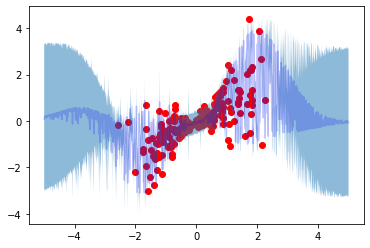

In [7]:
from gpflow.base import Parameter
from gpflow.utilities import positive
from sklearn.preprocessing import StandardScaler
import time
# tf.config.run_functions_eagerly(True)
from tqdm import trange


for i in wrong:
    print(f"Run number: {i}")
    if target[i] > 0:
        input = x[i]
        output = y[i]
    else:
        input = y[i]
        output = x[i]

    # input = np.linspace(1, 100, 100)[:, None]
    # output = input ** 2 + np.random.randn(100)[:, None]

    # print("Data created")
    X = np.random.randn(200, 1)
    Y = X + X * np.random.randn(200, 1)

    input = X
    output = Y

    input = StandardScaler().fit_transform(input).astype(np.float64)
    output = StandardScaler().fit_transform(output).astype(np.float64) 

    kernel_variance = 1.0
    # Likelihood variance
    kappa = np.random.uniform(
        low=10.0, high=100, size=[1]
    )
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1.0, high=100, size=[1]
    )

    latent_dim = 1
    num_inducing = 200

    kernel_lengthscale = 1. / lamda
    likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-6))

    kernel_lengthscale = 0.05
    likelihood_variance = 0.01

    # print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")


    noise_loss = get_noise_elbo(
        input=input,
        output=output,
        num_inducing=num_inducing
    )

    # Put in new values of hyperparams
    # X_mean_init = output - reg_gp_model.predict_y(input)[0]
    sq_exp = gpflow.kernels.SquaredExponential(
        lengthscales=[kernel_lengthscale] + [kernel_lengthscale / 3]
    )
    sq_exp.variance.assign(1)
    linear_kernel = gpflow.kernels.Linear(variance=1 + 1e-20)


    # sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale[0], kernel_lengthscale[1]])

    # linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    # poly_kernel = gpflow.kernels.Polynomial(degree=2, variance=kernel_variance)

    # sq_exp.variance.assign(kernel_variance)

    # quadratic_kernel = gpflow.kernels.Product([linear_kernel, linear_kernel_2])

    # kernel = poly_kernel
    kernel = gpflow.kernels.Sum([linear_kernel, sq_exp])
    # kernel_2 = gpflow.kernels.Sum([linear_kernel_2, sq_exp_2])
    # kernel = gpflow.kernels.SeparateIndependent(
    #     [
    #         kernel,  # This is k1, the kernel of f1
    #         kernel_2  # this is k2, the kernel of f2
    #     ]
    # )


    Z = gpflow.inducing_variables.InducingPoints(
        np.concatenate(
            [
                np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
                np.random.randn(num_inducing, 1),
            ],
            axis=1
        )
    )
    inducing_variable = Z
    # Z_2 = gpflow.inducing_variables.InducingPoints(
    #     np.concatenate(
    #         [
    #             np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
    #             np.random.randn(num_inducing, 1),
    #         ],
    #         axis=1
    #     )
    # )
    # inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    #     [
    #         Z,  # This is U1 = f1(Z1)
    #         Z_2,  # This is U2 = f2(Z2)
    #     ]
    # )
    X_mean_init = 0.01 * tf.cast(output, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (input.shape[0], latent_dim)), default_float()
    )

    m = PartObsBayesianGPLVM(
        data=output,
        in_data=input,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        inducing_variable=inducing_variable,
        jitter=1e-6
    )
    m.likelihood.variance = Parameter(
        likelihood_variance + 1e-20, transform=positive(lower=1e-6)
    )

    loss_fn = m.training_loss_closure()

    adam_vars = m.trainable_variables
    adam_opt = tf.optimizers.Adam(0.05)
    @tf.function
    def optimisation_step():
        adam_opt.minimize(loss_fn, adam_vars)

    # epochs = int(20e3)
    # log_freq = 100
    # with trange(1, epochs + 1) as pbar:
    #     losses = []
    #     for epoch in pbar:
    #         optimisation_step()
    #         if epoch % log_freq == 0:
    #             pbar.set_description(f"ELBO {- m.elbo()}")
    #         if epoch % 1000 == 0:
    #             obs_new = np.linspace(-5, 5, 1000)[:, None]

    #             Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
    #             Xnew = tf.cast(Xnew, dtype=default_float())
    #             Xnew = tf.concat(
    #                 [obs_new, Xnew], axis=1
    #             )
    #             pred_f_mean, pred_f_var = m.predict_y(
    #                 Xnew=Xnew,
    #             )
    #             plt.scatter(input[:, 0], output[:, 0], c='r')
    #             plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
    #             # plt.scatter(inducing_in, np.zeros(100) )
    #             plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
    #             plt.show()
    #             plt.close()
    #         losses.append(- m.elbo())
    #         if epoch > 101:
    #             losses.pop(0)
    #         if epoch > 1000 and np.abs(np.mean(losses[0:50]) - np.mean(losses[50:100])) < np.std(losses):
    #             print("BREAKING!")
    #             break                

    epochs = int(2e3)
    with trange(1, epochs + 1) as pbar:
        for epoch in pbar:
            optimisation_step()
            if - m.elbo() < noise_loss:
                print(f"Breaking as {- m.elbo()} is less than {noise_loss}")
                break


    # tf.print("ELBO:", - m.elbo())


    # Train everything
    # tf.print("Training everything")
    # gpflow.utilities.set_trainable(m.kernel, True)
    # gpflow.utilities.set_trainable(m.likelihood, False)
    # gpflow.utilities.set_trainable(m.X_data_mean , True)
    # gpflow.utilities.set_trainable(m.X_data_var, True)
    # gpflow.utilities.set_trainable(m.inducing_variable, True)
    # opt = gpflow.optimizers.Scipy()
    # opt_logs = opt.minimize(
    #     m.training_loss,
    #     m.trainable_variables,
    #     method="L-BFGS-B",
    #     options=dict(maxiter=200000),
    # )
    tf.print("Training everything")
    gpflow.utilities.set_trainable(m.kernel, True)
    gpflow.utilities.set_trainable(m.likelihood, True)
    gpflow.utilities.set_trainable(m.X_data_mean , True)
    gpflow.utilities.set_trainable(m.X_data_var, True)
    gpflow.utilities.set_trainable(m.inducing_variable, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=200000),
    )
    tf.print("ELBO:", - m.elbo(), noise_loss)

    tf.print(f"target: {target[i]}")
    loss = - m.elbo()

    tf.print(gpflow.utilities.print_summary(m))

    obs_new = np.linspace(-5, 5, 1000)[:, None]

    Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
    Xnew = tf.cast(Xnew, dtype=default_float())
    Xnew = tf.concat(
        [obs_new, Xnew], axis=1
    )
    pred_f_mean, pred_f_var = m.predict_y(
        Xnew=Xnew,
    )
    plt.scatter(input[:, 0], output[:, 0], c='r')
    plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
    # plt.scatter(inducing_in, np.zeros(100) )
    plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
    plt.show()
    plt.close()


In [ ]:
from models.BayesGPLVM import BayesianGPLVM


def get_marginal_noise_model_score(
    y: np.ndarray,
    num_inducing: int
):
    # Need to find the ELBO for a noise model
    linear_kernel = gpflow.kernels.Linear(variance=1)
    kernel = linear_kernel

    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, 1),
    )
    X_mean_init = 0.1 * tf.cast(y, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (y.shape[0], 1)), default_float()
    )
    x_prior_var = tf.ones((y.shape[0], 1), dtype=default_float())
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, 1),
    )
    # Define marginal model
    marginal_model = BayesianGPLVM(
        data=y,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        X_prior_var=x_prior_var,
        jitter=1e-6,
        inducing_variable=inducing_variable
    )
    marginal_model.likelihood.variance = Parameter(
        1, transform=positive(1e-6)
    )
    # Train everything
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        marginal_model.training_loss,
        marginal_model.trainable_variables,
        options=dict(maxiter=10000),
    )
    loss = - marginal_model.elbo()
    return loss

In [ ]:
def train_marginal_model(
    y: np.ndarray,
    num_inducing: int,
    kernel_variance: float,
    kernel_lengthscale: float,
    likelihood_variance: float,
    jitter: float,
):
    latent_dim = 1
    # Define kernel
    sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale])
    sq_exp.variance.assign(kernel_variance)
    linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
    # Initialise approx posteroir and prior
    X_mean_init = 0.1 * tf.cast(y, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (y.shape[0], latent_dim)), default_float()
    )
    x_prior_var = tf.ones((y.shape[0], latent_dim), dtype=default_float())
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, latent_dim),
    )

    # Define marginal model
    marginal_model = BayesianGPLVM(
        data=y,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        X_prior_var=x_prior_var,
        jitter=jitter,
        inducing_variable=inducing_variable
    )
    marginal_model.likelihood.variance = Parameter(
        likelihood_variance, transform=positive(1e-6)
    )

    # We will train the Adam until the elbo gets below the noise model score
    noise_elbo = get_marginal_noise_model_score(
        y=y,
        num_inducing=num_inducing
    )
    loss_fn = marginal_model.training_loss_closure()
    adam_vars = marginal_model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.05)
    @tf.function
    def optimisation_step():
        adam_opt.minimize(loss_fn, adam_vars)
    epochs = int(2e3)
    with trange(1, epochs + 1) as pbar:
        for epoch in pbar:
            optimisation_step()
            if - marginal_model.elbo() < noise_elbo:
                print(f"Breaking as {- marginal_model.elbo()} is less than {noise_elbo}")
                break

    # Train everything
    tf.print("Training everything")
    gpflow.utilities.set_trainable(marginal_model.kernel, True)
    gpflow.utilities.set_trainable(marginal_model.likelihood, True)
    gpflow.utilities.set_trainable(marginal_model.X_data_mean , True)
    gpflow.utilities.set_trainable(marginal_model.X_data_var, True)
    gpflow.utilities.set_trainable(marginal_model.inducing_variable, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        marginal_model.training_loss,
        marginal_model.trainable_variables,
        options=dict(maxiter=10000),
    )
    tf.print("ELBO:", - marginal_model.elbo())

    loss = - marginal_model.elbo()

    # Plot the fit to see if everything is ok
    obs_new = np.linspace(-5, 5, 1000)[:, None]

    pred_y_mean, pred_y_var = marginal_model.predict_y(
        Xnew=obs_new,
    )
    textstr = 'kern_len_lat=%.2f\nkern_var=%.2f\nlike_var=%.2f\nelbo=%.2f\n'%(
        marginal_model.kernel.kernels[0].lengthscales.numpy(),
        marginal_model.kernel.kernels[0].variance.numpy(),
        marginal_model.likelihood.variance.numpy(),
        - marginal_model.elbo().numpy()
    )
    plt.text(-8, 0, textstr, fontsize=8)
    plt.scatter(marginal_model.X_data_mean, y, c='r')
    plt.plot(obs_new, pred_y_mean, c='b', alpha=0.25)
    plt.fill_between(
        obs_new[:, 0],
        (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0],
        (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0],
        alpha=0.5
    )
    plt.show()
    plt.subplots_adjust(left=0.25)
    plt.close()
    return loss

# Try out CPDE

In [20]:
from models.GPCDE import GPCDE

In [57]:
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt


def run_optimizer(model, ds_iter, iterations):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(ds_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)
    iterator = trange(iterations) 
    for step in iterator:
        optimization_step()
        if step % 1000 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
            iterator.set_description(f"EPOCH: {step}, ELBO: {elbo}")


            obs_new = np.linspace(-8, 8, 3000)[:, None]

            lower, median, upper, samples = model.predict_credible_layer(
                Xnew=obs_new,
                obs_noise=True
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, median, c='b', alpha=0.2)
            # plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
            plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
            plt.show()
            plt.close()
            
    return logf

In [58]:
from sklearn.preprocessing import StandardScaler

# Get data
X = x[72]
Y = y[72]
# X = np.random.randn(200, 1)
# Y = X + X * np.random.randn(200, 1)
N = X.shape[0]
num_minibatch = 200


X = StandardScaler().fit_transform(X).astype(np.float64)
Y = StandardScaler().fit_transform(Y).astype(np.float64)

In [59]:
X.shape

(1500, 1)

In [60]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[1, 10]
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
kernel_2 = gpflow.kernels.Matern32(
    lengthscales=[0.1, 10]
)
# kernel_1.variance.assign(kernl_var)
kernel_3 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2, kernel_3])
Z = np.concatenate(
        [
            np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            # X[:M, :].copy(),
            np.random.randn(M, 1),
        ],
        axis=1
    )
model = GPCDE(
    kernel=kernel,
    likelihood=gpflow.likelihoods.Gaussian(
        variance=1e-5
        # variance=m.likelihood.variance.numpy(),
    ),
    inducing_variable=Z,
    num_quadrature=10,
    whiten=True
)
ds_iter = model._init_quadrature(X=X, Y=Y, num_minibatch=num_minibatch)

In [61]:
kernel_1

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1.0
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[ 1. 10.]


  0%|          | 0/50000 [00:00<?, ?it/s]

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2838, in while_loop
    return result  File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2786, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/tensorflow/python/ops/map_fn.py", line 493, in compute
    return (i + 1, tas)  File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/tensorflow/python/ops/map_fn.py", line 491, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "/vol/bitbucket/ad6013/envs/gp-causal

EPOCH: 0, ELBO: -1592553.5398231144:   0%|          | 0/50000 [00:01<?, ?it/s]

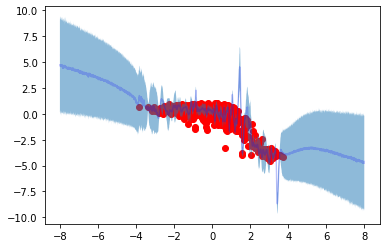

EPOCH: 1000, ELBO: -59649.769861784785:   2%|▏         | 995/50000 [00:18<12:05, 67.55it/s]

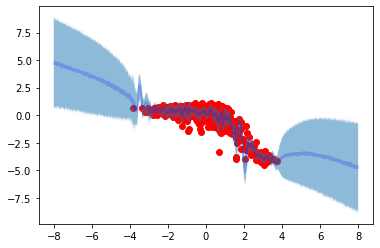

EPOCH: 2000, ELBO: -21456.950979765556:   4%|▍         | 1996/50000 [00:36<11:46, 67.93it/s]  

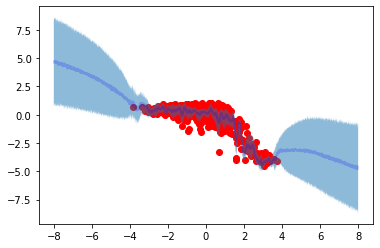

EPOCH: 3000, ELBO: -12742.160202967183:   6%|▌         | 2997/50000 [00:53<11:31, 67.93it/s]  

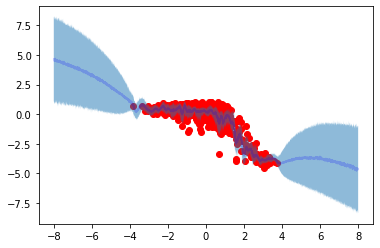

EPOCH: 4000, ELBO: -12819.03640240213:   8%|▊         | 3998/50000 [01:10<11:18, 67.78it/s]   

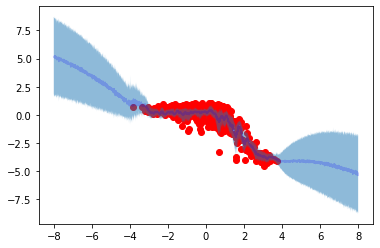

EPOCH: 5000, ELBO: -5402.539241539767:  10%|▉         | 4999/50000 [01:27<10:54, 68.72it/s]  

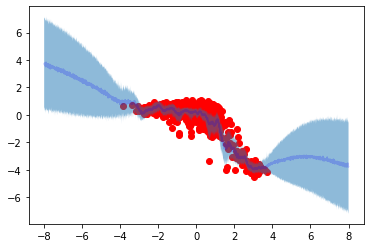

EPOCH: 6000, ELBO: -3770.7589130984675:  12%|█▏        | 6000/50000 [01:44<10:44, 68.27it/s] 

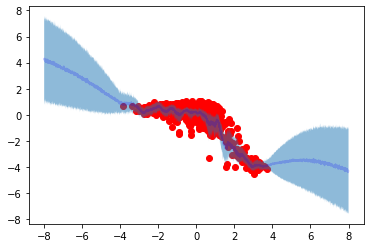

EPOCH: 7000, ELBO: -2900.8575657385263:  14%|█▍        | 6994/50000 [02:01<10:30, 68.18it/s]  

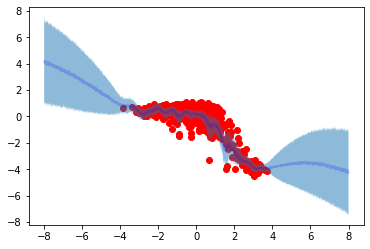

EPOCH: 8000, ELBO: -1646.3180537109763:  16%|█▌        | 7995/50000 [02:18<10:07, 69.11it/s]  

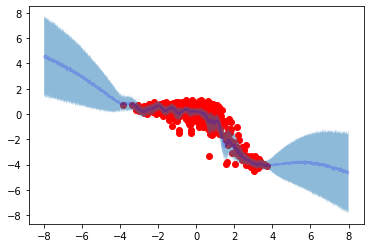

EPOCH: 9000, ELBO: -1059.735290655789:  18%|█▊        | 8997/50000 [02:35<09:55, 68.80it/s]   

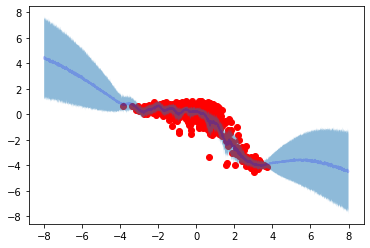

EPOCH: 10000, ELBO: -926.5743341367362:  20%|██        | 10000/50000 [02:52<09:43, 68.53it/s]

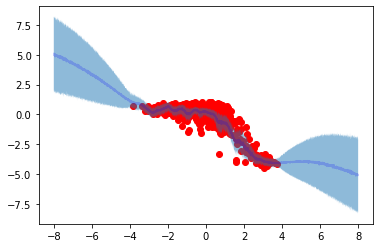

EPOCH: 11000, ELBO: -627.7738922300011:  22%|██▏       | 10994/50000 [03:09<09:34, 67.84it/s]  

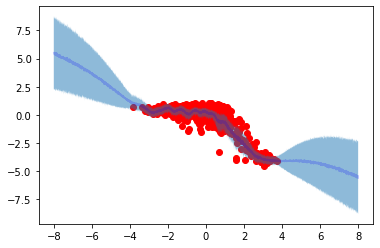

EPOCH: 12000, ELBO: -496.05295444062875:  24%|██▍       | 11995/50000 [03:26<09:12, 68.75it/s] 

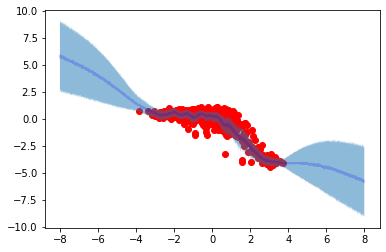

EPOCH: 13000, ELBO: -258.389841185861:  26%|██▌       | 12996/50000 [03:43<08:59, 68.53it/s]    

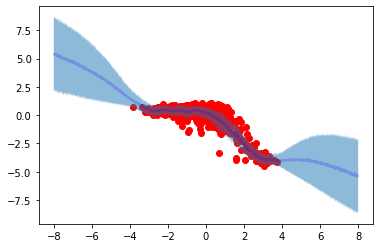

EPOCH: 14000, ELBO: -297.9336961733155:  28%|██▊       | 14000/50000 [04:01<10:21, 57.92it/s] 


KeyboardInterrupt: 

In [62]:
_ = run_optimizer(
    model=model,
    ds_iter=ds_iter,
    iterations=50000
)

In [ ]:
from gpflow.quadrature import NDiagGHQuadrature


num_quadrature = 10
def init_quadrature(X, Y, num_minibatch = 100):
    num_data= X.shape[0]
    num_dim = X.shape[1]
    num_minibatch = num_minibatch
    quadrature = NDiagGHQuadrature(1, num_quadrature)
    quadrature_locs, quadrature_weights = quadrature._build_X_W(np.zeros(1), np.ones(1))
    quadrature_weights = quadrature_weights[:,0]
    quadrature_weights = quadrature_weights[None, :]
    quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
    quadrature_locs = tf.tile(quadrature_locs, multiples=[X.shape[0],1,1])
    X = X[:,None,:]
    Y = Y[:,None,:]
    X = tf.tile(X, multiples=[1, num_quadrature, 1])
    Y = tf.tile(Y, multiples=[1, num_quadrature, 1])
    X = tf.concat([X, quadrature_locs],axis=-1)
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds_iter = iter(ds.batch(num_minibatch))
    return ds_iter


ds_iter = init_quadrature(X, Y, num_minibatch=200)
model.num_minibatch = 200
print(model.num_minibatch)
print(model.num_quadrature)
print(model.num_dim)
print(f"ELBO: {- model.elbo(data=next(ds_iter))}")

In [ ]:
from gpflow.quadrature import NDiagGHQuadrature


num_quadrature = 10
def init_quadrature(X, Y, num_minibatch = 100):
    num_data= X.shape[0]
    num_dim = X.shape[1]
    num_minibatch = num_minibatch
    quadrature = NDiagGHQuadrature(1, num_quadrature)
    quadrature_locs, quadrature_weights = quadrature._build_X_W(np.zeros(1), np.ones(1))
    quadrature_weights = quadrature_weights[:,0]
    quadrature_weights = quadrature_weights[None, :]
    quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
    quadrature_locs = tf.tile(quadrature_locs, multiples=[X.shape[0],1,1])
    X = X[:,None,:]
    Y = Y[:,None,:]
    X = tf.tile(X, multiples=[1, num_quadrature, 1])
    Y = tf.tile(Y, multiples=[1, num_quadrature, 1])
    X = tf.concat([X, quadrature_locs],axis=-1)
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds_iter = iter(ds.batch(num_minibatch))
    return ds_iter


ds_iter = init_quadrature(X, Y, num_minibatch=200)
model.num_minibatch = 200
print(model.num_minibatch)
print(model.num_quadrature)
print(model.num_dim)
print(f"ELBO: {- model.elbo(data=next(ds_iter))}")

200
10
1
ELBO: 2371.0984522030817


In [ ]:
model.likelihood.variance

<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.0006511933289427105>

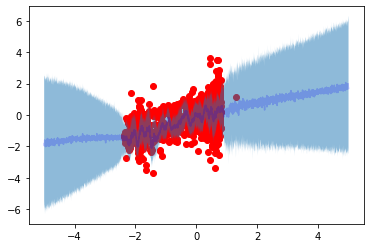

In [ ]:
import matplotlib.pyplot as plt

obs_new = np.linspace(-5, 5, 3000)[:, None]

lower, median, upper, samples = model.predict_credible_layer(
    Xnew=obs_new,
    obs_noise=False
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, median, c='b', alpha=0.2)
# plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
plt.show()
plt.close()

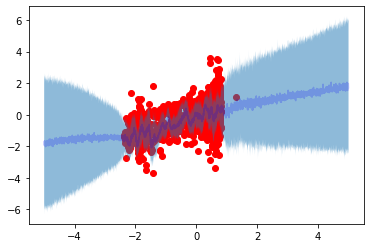

In [ ]:
import matplotlib.pyplot as plt

obs_new = np.linspace(-5, 5, 3000)[:, None]

lower, median, upper, samples = model.predict_credible_layer(
    Xnew=obs_new,
    obs_noise=False
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, median, c='b', alpha=0.2)
# plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
plt.show()
plt.close()

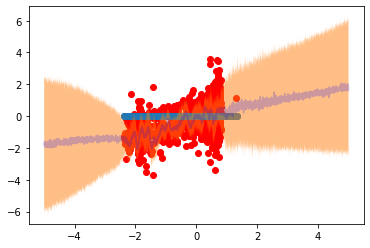

In [36]:
import matplotlib.pyplot as plt

obs_new = np.linspace(-5, 5, 3000)[:, None]

lower, median, upper, samples = model.predict_credible_layer(
    Xnew=obs_new,
    obs_noise=True
)
inducing = model.inducing_variable.Z[:, 0]
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, median, c='b', alpha=0.2)
plt.scatter(inducing.numpy(), np.zeros(inducing.shape[0]))
# plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
plt.show()
plt.close()

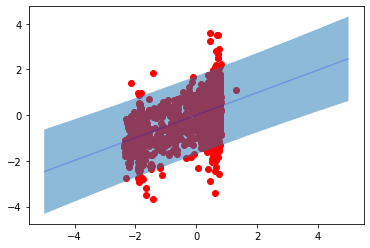

In [71]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], 1])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()


In [72]:
gpflow.utilities.print_summary(model)

╒══════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                 │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞══════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ GPCDE.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.3192343770204038e-06                               │
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ GPCDE.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)          │ flo